Running 19x72 = 1368 simulations...
Progress: 1368/1368 (100.0%) - ETA: 0:00:00
Simulation complete!
Completed in 0:00:59

▶ Best tilt     = 30°
▶ Best azimuth  = 5°
▶ Annual AC     = 1382.6 kWh per kW installed

Top 5 Best Combinations:
     tilt  azimuth  annual_ac_kWh
433    30        5    1382.630765
432    30        0    1382.360953
434    30       10    1381.139847
503    30      355    1379.809821
361    25        5    1379.319996


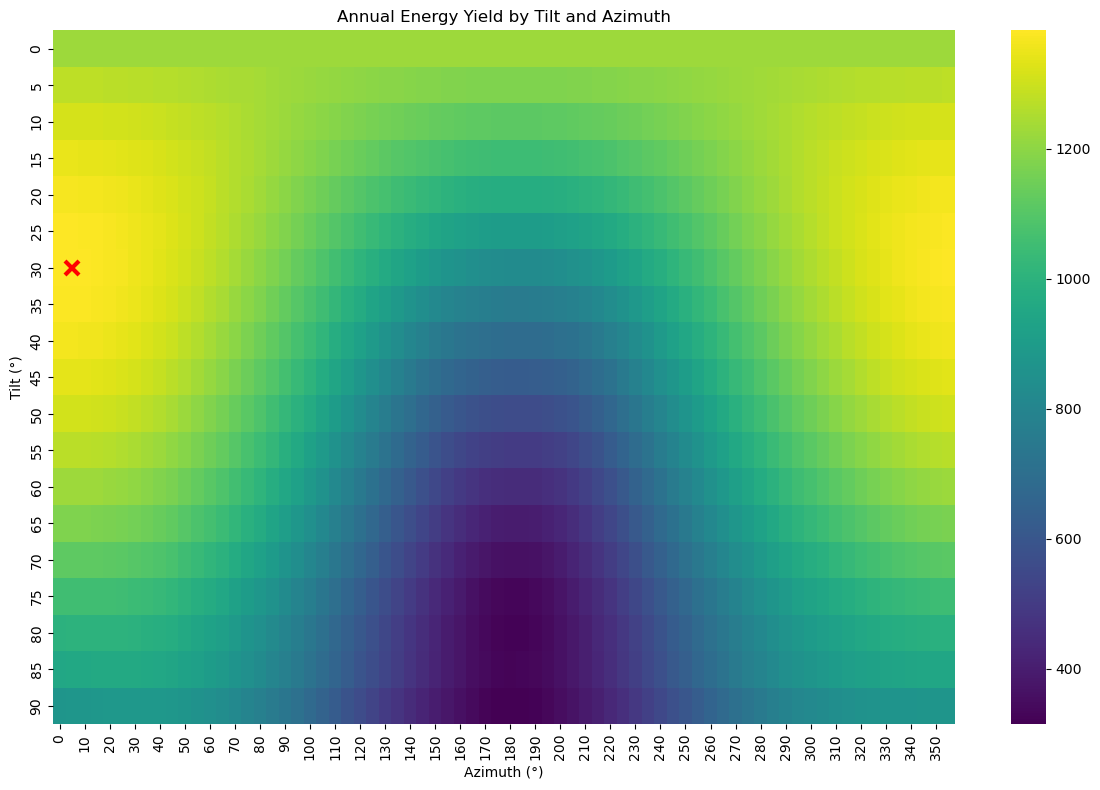

In [1]:
# Cell 1: Imports & Paths
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import PySAM.Pvwattsv8 as pv
import time
from datetime import timedelta
import sys  # For progress tracking

# 1) EPW file & site coords (in header)
project_root = Path.cwd().parent
epw_file = project_root/"data"/"Bonfire_2025.epw"
assert epw_file.exists(), f"EPW not found: {epw_file}"

# 2) Tilt & azimuth ranges - 5 degree steps for both
tilts = np.arange(0, 91, 5)     # 0°, 5°, 10°, ..., 90°
azis = np.arange(0, 360, 5)     # 0°, 5°, 10°, ..., 355°

# Optional: Print number of combinations
total_sims = len(tilts) * len(azis)
print(f"Running {len(tilts)}x{len(azis)} = {total_sims} simulations...")

# Cell 2: Grid-search with Pvwattsv8 (using pv.new())
records = []
start_time = time.time()
counter = 0

try:
    for tilt in tilts:
        for azi in azis:
            # Show progress
            counter += 1
            if counter % 10 == 0 or counter == 1 or counter == total_sims:
                percent_done = (counter / total_sims) * 100
                elapsed = time.time() - start_time
                eta = (elapsed / counter) * (total_sims - counter) if counter > 0 else 0
                print(f"Progress: {counter}/{total_sims} ({percent_done:.1f}%) - ETA: {timedelta(seconds=int(eta))}", end="\r")
                sys.stdout.flush()
            
            # 1) Instantiate a fresh model
            model = pv.new()
            # 2) Point it at the EPW – lat/lon come from the file header
            model.SolarResource.solar_resource_file = str(epw_file)
            # 3) Define a 1 kW fixed rack system with 14% losses
            model.SystemDesign.system_capacity = 1.0   # kW
            model.SystemDesign.module_type     = 0     # standard module
            model.SystemDesign.array_type      = 0     # fixed rack
            model.SystemDesign.losses          = 14.0  # 14%
            
            # 4) Surface orientation
            model.SystemDesign.tilt    = float(tilt)
            model.SystemDesign.azimuth = float(azi)
            
            # 5) Run the annual sim
            model.execute()
            
            # 6) Record the annual AC output
            records.append((tilt, azi, model.Outputs.ac_annual))
    
    print("\nSimulation complete!")
    elapsed_time = time.time() - start_time
    print(f"Completed in {timedelta(seconds=int(elapsed_time))}")

except Exception as e:
    print(f"\nAn error occurred: {str(e)}")
    # If we have at least some results, continue to plotting
    if len(records) == 0:
        print("No results to display.")
        raise

# Cell 3: Collate results & find/visualize the best combination
res = pd.DataFrame(records, columns=["tilt", "azimuth", "annual_ac_kWh"])
best = res.loc[res.annual_ac_kWh.idxmax()]

# Print the best results
print(f"\n▶ Best tilt     = {best.tilt:.0f}°")
print(f"▶ Best azimuth  = {best.azimuth:.0f}°")
print(f"▶ Annual AC     = {best.annual_ac_kWh:.1f} kWh per kW installed")

# Display the top 5 best combinations
print("\nTop 5 Best Combinations:")
top5 = res.sort_values(by='annual_ac_kWh', ascending=False).head(5)
print(top5)

# Create a heatmap to visualize all results
pivot_table = res.pivot(index="tilt", columns="azimuth", values="annual_ac_kWh")
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap="viridis", annot=False)
plt.title('Annual Energy Yield by Tilt and Azimuth')
plt.xlabel('Azimuth (°)')
plt.ylabel('Tilt (°)')

# Mark the best point
best_x = np.where(pivot_table.columns == best.azimuth)[0][0]
best_y = np.where(pivot_table.index == best.tilt)[0][0]
plt.plot(best_x + 0.5, best_y + 0.5, 'rx', markersize=10, markeredgewidth=3)
plt.tight_layout()
plt.show()